# Building Simple CNN Networks

## Data Loading

In [1]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image

- docs: https://www.tensorflow.org/api_docs/python/tf/WholeFileReader

In [2]:
# 현재 디렉토리를 이용해서 파일 이름을 확인한다.
# for dir in os.listdir(os.getcwd()):
#     print dir

In [3]:
image_path1 = os.getcwd() + '/image.png'
image_path2 = os.getcwd() + '/image-grayscaled.png'
label_path1 = os.getcwd() + '/label1.csv'
label_path2 = os.getcwd() + '/label2.csv'

filename_list = [image_path1, image_path2]
labelname_list = [label_path1, label_path2]

filename_queue = tf.train.string_input_producer(filename_list)
labelname_queue = tf.train.string_input_producer(labelname_list)


In [4]:
image_reader = tf.WholeFileReader()
label_reader = tf.TextLineReader()

image_key, image_value = image_reader.read(filename_queue)
label_key, label_value = label_reader.read(labelname_queue)

In [5]:
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess=sess, coord=coord)

    _image_key, _label_key = sess.run([image_key, label_key])

    print _image_key
    print _label_key

    coord.request_stop()
    coord.join(thread)

/Users/johnpark82/workspace/MLND/MLND-Sandbox/TensorFlow/image-grayscaled.png
/Users/johnpark82/workspace/MLND/MLND-Sandbox/TensorFlow/label1.csv:1


- Encoding and Decoding : https://www.tensorflow.org/api_guides/python/image

In [6]:
images = tf.image.decode_png( image_value )
label = tf.decode_csv( label_value, record_defaults=[ [0] ])

x = tf.cast(images, tf.float32)
y_ = tf.cast(label, tf.float32)


In [7]:
print x
print y_

Tensor("Cast:0", shape=(?, ?, ?), dtype=float32)
Tensor("Cast_1:0", shape=(1,), dtype=float32)


## Build Neural Network

- Reference : https://www.tensorflow.org/get_started/mnist/pros

### Placeholder - Input Data Tensor

In [8]:
image_width = 100
image_height = 100
image_channel = 3


In [9]:
#x = tf.placeholder( tf.float32, shape=[None, image_width, image_width, image_channel]  )
# y_ = tf.placeholder( tf.float32, shape=[None, 2] )


### Variables - Weight Tensor

In [10]:
# Convolution Layer 1
hidden1_w = tf.Variable( tf.truncated_normal([5, 5, image_channel, 32]) )
hidden1_b = tf.Variable( tf.zeros([32]) )

# Convolution Layer 2
hidden2_w = tf.Variable(tf.truncated_normal([5, 5, 32, 64]))
hidden2_b = tf.Variable(tf.zeros([64]))

# Densely Connected Layer
fully_connected_w = tf.Variable(tf.truncated_normal([image_width/2/2*image_height/2/2*64, 1024]))
fully_connected_b = tf.Variable(tf.zeros([1024]))

# Dropout
keep_prob = tf.placeholder(tf.float32)

# Readout Layer
output_w = tf.Variable(tf.truncated_normal([1024, 1]))
output_b = tf.Variable(tf.zeros([1]))


In [11]:
# Conv Layer 1
x_image = tf.reshape(x, [-1, image_width, image_height,3])
y_ = tf.reshape(y_, [-1, 1])

hidden1_layer = tf.nn.relu(tf.nn.conv2d(x_image, hidden1_w, strides=[1, 1, 1, 1], padding='SAME') + hidden1_b)
hidden1_pool = tf.nn.max_pool(hidden1_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Conv Layer 2
hidden2_layer = tf.nn.relu(tf.nn.conv2d(hidden1_pool, hidden2_w, strides=[1, 1, 1, 1], padding='SAME') + hidden2_b)
hidden2_pool = tf.nn.max_pool(hidden2_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Densely(Fully) Connected Layer
hidden_pool2_flat = tf.reshape(hidden2_pool, [-1, image_width/2/2*image_height/2/2*64])
hidden_fc1 = tf.nn.relu(tf.matmul(hidden_pool2_flat, fully_connected_w) + fully_connected_b)

# Dropout
hidden_fc1_dropout = tf.nn.dropout(hidden_fc1, keep_prob)


- Convolution 네트워크는 종료되고 Feed Forward Neural Network

In [12]:
#Readout Layer
prediction = tf.matmul(hidden_fc1_dropout, output_w) + output_b


In [13]:
# Calculate loss (Evaluate performance) and doing back propagation
cross_entropy = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits( labels=y_, logits= prediction ) )
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Preprocessing - Test for showing the images

In [14]:
with tf.Session() as sess:
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess, coord)

    # CNN학습을 진행한다.
    sess.run(tf.global_variables_initializer())

    for i in range(10):
        _, _loss, _accuracy = sess.run([train_step, cross_entropy, accuracy], feed_dict={keep_prob: 0.5})
        print "----------"
        print "loss: ", _loss
        print "accuracy: ", _accuracy

    coord.request_stop()
    coord.join()
    print 'Convolution Network Training is done'

sess.close()


----------
loss:  0.0
accuracy:  1.0
Convolution Network Training is done


----------
loss:  0.0
accuracy:  1.0


----------
loss:  0.0
accuracy:  1.0


----------
loss:  0.0
accuracy:  1.0


----------
loss:  0.0
accuracy:  1.0


----------
loss:  0.0
accuracy:  1.0


----------
loss:  0.0
accuracy:  1.0


----------
loss:  0.0
accuracy:  1.0


----------
loss:  0.0
accuracy:  1.0


----------
loss:  0.0
accuracy:  1.0


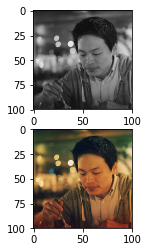

0
1


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess, coord)

    # 입력받은 이미지를 출력한다.
    fig = plt.figure()

    for i in range(len(filename_list)):
        image = sess.run( images )

        original = Image.fromarray(image)
        fig.add_subplot(2,1,i+1)
        imgplot = plt.imshow(np.asarray(original))

        print i

    coord.request_stop()
    coord.join()

sess.close()


- 컴퓨터의 벡터 연산과 수학에서 표현하는 벡터간의 표현차이

In [16]:
import numpy as np

vector_in_computer = [[1,2,3,4,5], [6,7,8,9,10]]
print vector_in_computer
print np.shape(vector_in_computer)

vector_in_math = [[1], [2], [3], [4], [5]]
print vector_in_math
print np.shape(vector_in_math)


[[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]]
(2, 5)
[[1], [2], [3], [4], [5]]
(5, 1)
